# Project: Integrated Project 2

**Project Description**

You work at a startup that sells food products. You need to analyze user behavior for your company application.

It is an integrated project that combine all of previous subject, especially Business Analytics, A/B Testing, and Data Storytelling.

## Introduction

As a data analyst for a startup that sells food products, it's essential to understand user behavior for the company's app. In this project, we'll investigate the **sales funnel** and study **user behavior** using an **A/A/B test** to see how **changes to the app's font** will **impact user engagement**.

We'll begin by analyzing the sales funnel to understand how users **reach the purchase stage**, how many users make it to this stage, and **which stages have the most drop-offs**. Then, we'll move on to the A/A/B test, where users are split into three groups: two control groups that receive the old fonts and one test group that receives the new fonts. We'll determine **which** set of fonts **produces better results** and confirm if the test groups were split correctly.

We'll be using a dataset that combines general data and A/A/B analysis data to conduct our study. This project will test our abilities in data cleaning, data visualization, hypothesis testing, and statistics.

Let's dive in and see what insights we can uncover from this analysis.

### Project Path

To complete this project, we'll need to perform the following steps:
- **Open the data file and read the general information**.
- **Prepare the data for analysis** by renaming columns, checking for missing values and correcting data types. Add a date and time column and a separate column for dates.
- Study and check the data to determine:
    - the **number of events and users in the logs**,
    - the **average number of events per user**, and
    - the **period of time the data covers**.
    - Plot a **histogram** by date and time to determine whether you have equally complete data for the entire period. Find the moment at which the data starts to be complete and ignore the earlier section. Make sure you have users from all three experimental groups.
- Study the **event funnel** by determine:
    - the **frequency of occurrence for each event** in the logs,
    - the **number of users who performed each action**, and
    - the **proportion** of users who **performed** each action **at least once**.
    - Use the event funnel to **find the share of users that proceed from each stage** to the next. Identify the **stage at which you lose the most users** and **determine the share of users that make the entire journey** from their first event to payment.
- Study the results of the experiment by determining the **number of users in each group**, checking for a **statistically significant difference between samples** 246 and 247, and **comparing the results** of the group with altered fonts to those of the control groups. Calculate the **significance level** and determine the number of statistical hypothesis tests you carried out. If necessary, adjust the significance level and repeat the previous steps.

### Data dictionary
**The logs_exp_us table:**
    
- `EventName` — event name
- `DeviceIDHash` — unique user identifier
- `EventTimestamp` — event time
- `ExpId` — experiment number: 246 and 247 are the control groups, 248 is the test group

## Data Preprocessing

In [5]:
# importing libraries
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objs as go

In [6]:
# data loading
df_logs_exp = pd.read_csv('logs_exp_us.csv', sep='\t')

### Dataframe df_logs_exp

In [7]:
# general information
df_logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
# metric information
df_logs_exp.describe()

DeviceIDHash  EventTimestamp          ExpId
count  2.441260e+05    2.441260e+05  244126.000000
mean   4.627568e+18    1.564914e+09     247.022296
std    2.642425e+18    1.771343e+05       0.824434
min    6.888747e+15    1.564030e+09     246.000000
25%    2.372212e+18    1.564757e+09     246.000000
50%    4.623192e+18    1.564919e+09     247.000000
75%    6.932517e+18    1.565075e+09     248.000000
max    9.222603e+18    1.565213e+09     248.000000

In [9]:
# dataframe size
df_logs_exp.shape

(244126, 4)

In [10]:
# looking at the first rows of the df_orders dataframe
df_logs_exp.head()

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

In [11]:
# checking column names
df_logs_exp.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [12]:
# renaming the columns
df_logs_exp = df_logs_exp.rename(columns={'EventName': 'name', 'DeviceIDHash': 'user_id', 
                                          'EventTimestamp': 'ts', 'ExpId' : 'group'})

In [13]:
# Replacing numeric groups with coded groups
df_logs_exp['group'] = df_logs_exp['group'].replace({246: 'A1', 247: 'A2', 248: 'B'})

In [14]:
# changing the format of the ts column
df_logs_exp['ts'] = pd.to_datetime(df_logs_exp['ts'], unit='s')
df_logs_exp['date'] = df_logs_exp['ts'].dt.floor('1D')

In [15]:
# checking for unique values in name column
df_logs_exp['name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [16]:
# replace the names in the name column
df_logs_exp['name'] = df_logs_exp['name'].replace({'MainScreenAppear': 'main_screen_appear', 
                                                   'OffersScreenAppear': 'offers screen appear', 
                                                   'CartScreenAppear': 'cart screen appear', 
                                                   'PaymentScreenSuccessful': 'payment screen successful', 
                                                   'Tutorial': 'tutorial'})

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Bom trabalho com as transformações das colunas. Nesse último ponto, uma sugestão: procure não usar nomes de colunas com espaço em branco, pois isso torna mais fácil a ocorrência de erros. Opte, por exemplo, por usar o padrão `snake case`, que é o padrão recomendado em python. Inclusive, você pode criar uma função que faz essa transformação ("slugify") de maneira automatizada.
</div>

In [17]:
# checking name count
df_logs_exp['name'].value_counts()

name
main screen appear           119205
offers screen appear          46825
cart screen appear            42731
payment screen successful     34313
tutorial                       1052
Name: count, dtype: int64

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Correto. Sugestão: `.value_counts(normalize=True)`.
</div>

In [18]:
# checking for duplicate data
df_logs_exp.duplicated().sum()

413

In [19]:
# removing duplicate data
df_logs_exp = df_logs_exp.drop_duplicates()

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Correto, mas considere fazer a operação inplace: `drop_duplicates(inplace=True)`.
</div>

In [20]:
# checking for duplicate data again
df_logs_exp.duplicated().sum()

0

In [21]:
# checking for duplicate data
df_logs_exp.isna().sum()

name       0
user_id    0
ts         0
group      0
date       0
dtype: int64

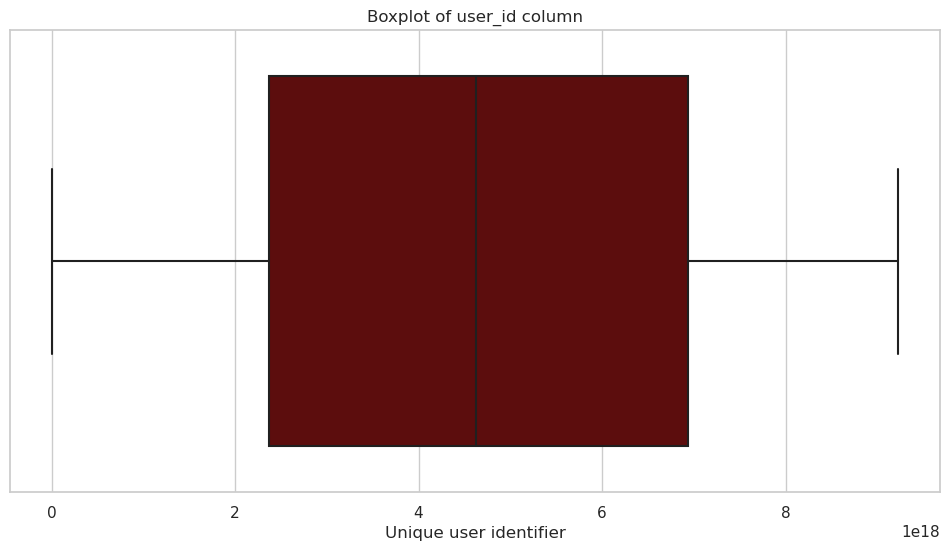

In [22]:
# boxplot of the user_id column
sns.set(style="whitegrid", palette="hot")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_logs_exp, x='user_id')
plt.title('Boxplot of user_id column')
plt.xlabel('Unique user identifier')
plt.show()

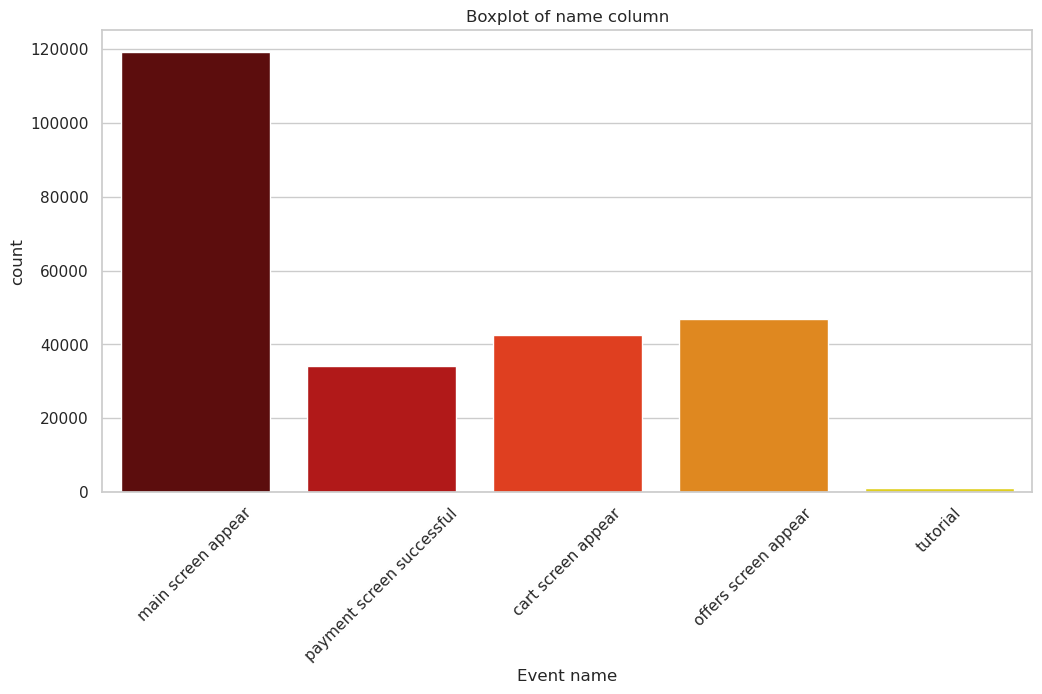

In [23]:
# countplot of the name column
sns.set(style="whitegrid", palette="hot")
plt.figure(figsize=(12, 6))
sns.countplot(data=df_logs_exp, x='name')

plt.title('Boxplot of name column')
plt.xlabel('Event name')
plt.xticks(rotation=45)
plt.show()

### Final Dataframe 

*In the initial data preparation, we have made some modifications to the dataset, including renaming some columns to more meaningful names, replacing certain values with more understandable ones, and converting the timestamp column into a datetime format. Now, let's take a look at the final dataframe using the `head()` and `info()` functions.*

*We can use these functions to ensure that our modifications have been correctly applied and that the dataframe is ready for further analysis.*

In [24]:
# general information again
df_logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   name     243713 non-null  object        
 1   user_id  243713 non-null  int64         
 2   ts       243713 non-null  datetime64[ns]
 3   group    243713 non-null  object        
 4   date     243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 11.2+ MB


**Description of the data df_logs_exp:**

*Each log entry is a user action or an event.*
- `name` — event name
- `user_id` — unique user identifier
- `ts` — event time stamp
- `group` — experiment number: A1 and A2 are the control groups, B is the test group
- `date` — event date

In [25]:
# looking at the first rows of the df_orders dataframe again
df_logs_exp.head()

name              user_id                  ts group  \
0         main screen appear  4575588528974610257 2019-07-25 04:43:36    A1   
1         main screen appear  7416695313311560658 2019-07-25 11:11:42    A1   
2  payment screen successful  3518123091307005509 2019-07-25 11:28:47     B   
3         cart screen appear  3518123091307005509 2019-07-25 11:28:47     B   
4  payment screen successful  6217807653094995999 2019-07-25 11:48:42     B   

        date  
0 2019-07-25  
1 2019-07-25  
2 2019-07-25  
3 2019-07-25  
4 2019-07-25

**Overview of df_logs_exp:**
- *there are four columns `EventName`, `DeviceIDHash`, `EventTimestamp` and `ExpId`, all have 244126 rows*;
- *the `EventName` column is of type object, the `DeviceIDHash`, `EventTimestamp` and `ExpId` columns are of type int64*;
- *column name changed from `EventName` to `name`*;
- *column name changed from `DeviceIDHash` to `user_id`*;
- *column name changed from `EventTimestamp` to `ts`*;
- *column name changed from `ExpId` to `group`*;
- *the type of column `ts` was changed from int64 to datetime64[ns]*;
- *a new column called `date` was added to store only the date of the event*;
- *there is no big difference between the mean and median in the `user_id` and `group` column*;
- *there is no difference between the mean and median in the `ts` column*;
- *there are duplicate data in the dataframe, it was removed an dnow the dataframe has 243713 rows*;
- *no ouliers in the `user_id` column*;
- *no missing data in the dataframe*.

## Data Exploration

In this section, we will be studying and checking the data to gain a better understanding of the dataset that we will be working with. We will be answering important questions such as the number of events and users in the logs, the average number of events per user, and the period of time that the data covers. 

Additionally, we will be investigating the completeness of the data by finding the maximum and minimum dates, and identifying any technical issues that might have affected the data. Finally, we will ensure that we have users from all three experimental groups to avoid any bias in our analysis.

### Number of Events 

In [26]:
df_logs_exp['name'].value_counts()

name
main screen appear           119101
offers screen appear          46808
cart screen appear            42668
payment screen successful     34118
tutorial                       1018
Name: count, dtype: int64

*There are **5 events** that happening throughout the users journey through the app.*
- **main_screen_appear** — where users viewed the main page
- **offers screen appear** — where users went to the product page that the app currently offer
- **cart screen appear** — where users viewed the cart page
- **payment screen successful** — which appear after users completed the payment
- **tutorial** — is a special page that doesn't seems logical to be included in the event funnel. This event occurs for when users went to the tutorial page to get help regarding the use of the app.

### Number of Users

*This code includes two methods to count the number of events and the number of distinct users in a Pandas dataframe.*

*The first method `df_logs_exp['user_id'].count()` uses the `count()` method to count the number of events in the `'user_id'` column of the dataframe `df_logs_exp`. The `count()` method returns the number of non-null values in the specified column, which can be used as a proxy for the **total number of events** in the dataframe.*

*The second method `df_logs_exp['user_id'].nunique()` uses the `nunique()` method to count the number of unique values in the `'user_id'` column of the dataframe `df_logs_exp`. The `nunique()` method returns the number of unique values in the specified column, which can be used as a proxy for the **total number of distinct users** in the dataframe.*

*Both methods are useful for understanding the size and complexity of a dataset, and can be used to answer questions such as `"How many events were recorded in the dataset?"` and `"How many unique users participated in the study?"`.*

In [27]:
# count the number of events
df_logs_exp['user_id'].count()

243713

In [28]:
# count the number of distinct user
df_logs_exp['user_id'].nunique()

7551

*It turns out that there is **243,713 events** occuring in total completed by **7,551 users**.*

### Average Number of Events per User 

*To obtain the average number of events per user, we can use the following code:*

In [29]:
avg_events_per_user = df_logs_exp['user_id'].count() / df_logs_exp['user_id'].nunique()

avg_events_per_user

32.27559263673685

*This calculates the total number of events divided by the number of unique users, resulting in **the average number of events per user**, which **is 32.27%**.*

### Exploring the Timeframe of Data 

In this section, we will investigate the log data to determine the period of time that it covers and to check the completeness of the data. We will start by finding the minimum and maximum dates of the log data and plot a histogram by date and time to visualize the distribution of events over time. We will then analyze the completeness of the data, as older events could skew the overall picture if they end up in some users' logs for technical reasons. 

Finally, we will find the moment at which the data starts to be complete and ignore the earlier section. By the end of this section, we will have a clear understanding of the period that the data covers and how complete it is, which will be essential for further analysis.

In [30]:
# find the minimum and maximum date
print('Minimum date:', df_logs_exp['ts'].min())
print('Maximum date:', df_logs_exp['ts'].max())

Minimum date: 2019-07-25 04:43:36
Maximum date: 2019-08-07 21:15:17


*This code finds the earliest and latest date in the dataset. It prints out the minimum date and maximum date, which is helpful to get an idea about the overall period of time covered by the data. Knowing the period of time covered by the data is important for data analysis and interpretation.*

In [31]:
# Define the histogram trace
trace = go.Histogram(x=df_logs_exp['ts'],
                     nbinsx=50,
                     marker=dict(color='#b50404'),
                     opacity=0.80)

# Define the layout
layout = go.Layout(title='Histogram of Timestamp',
                   xaxis=dict(title='Time Stamp'),
                   yaxis=dict(title='Count of Users'),
                   margin=dict(l=100, r=50, b=50, t=50),)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.update_traces(marker_line_width=1,marker_line_color="white")
fig.show()

*We have created a histogram plot to visualize the distribution of timestamps in our dataset. The x-axis shows the different timestamps, and the y-axis shows the count of users. The plot is designed to help us understand how many events happened at different times in our data.*

*Looking at the resulting graph, we can see that there is a sudden and significant spike in the count of users around late July to early August. This indicates that there was a high number of events occurring starting from this time period. To investigate this further, we need to create another plot that can help us see this spike more clearly.*

In [32]:
temp_pivot = df_logs_exp.pivot_table(index='date', values='user_id', aggfunc='count')

# Define data and layout
data = go.Scatter(x=temp_pivot.index,
                  y=temp_pivot['user_id'],
                  mode='lines+markers',
                  marker=dict(color='#b50404'),
                  line=dict(width=2))

layout = go.Layout(title='User Activity by Date',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Count of Users'),
                   margin=dict(l=100, r=100, t=50, b=50),)

# Create figure
fig = go.Figure(data=[data], layout=layout)

# Show the figure
fig.show()

*The resulting graph shows the count of users per date over the entire period of the data. Each point on the graph represents a date, and the height of the point indicates the number of users who engaged in events on that date. The line connecting the points helps us to see any trends or patterns in the data.*

*By looking at the graph, it is easier to notice a sudden burst of events occuring in the 1st of August. An issue like this could occur because Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Therefore, we must remove the older events.*

### Removing Older Data 

Based on the previous section, we will continue our analysis with the data starting on the 1st of August. This following code creates a new DataFrame named `df_logs_exp_2` which is assigned to the same data as `df_logs_exp`.

The `query()` method is then used to filter the data so that only rows where the timestamp ts is greater than `"2019-08-01 00:00"` are kept. The `inplace=True` argument means that the `df_logs_exp_2` DataFrame is updated with the filtered data and no new DataFrame is created. Finally, the `head()` method is called to display the first few rows of the filtered DataFrame.

In [33]:
df_logs_exp_2 = df_logs_exp.query('ts >= "2019-08-01 00:00"')

*Before we continue, we have to investigate further into the impact of removing the older data.*

In [34]:
print('Number of events from original dataframe:', '{:,}'.format(len(df_logs_exp)),'events')
print('Number of events from filtered dataframe:', '{:,}'.format(len(df_logs_exp_2)),'events')
print('Percent of removed events:', '{:.2%}'.format((len(df_logs_exp) - len(df_logs_exp_2)) / len(df_logs_exp)))

Number of events from original dataframe: 243,713 events
Number of events from filtered dataframe: 240,887 events
Percent of removed events: 1.16%


In [35]:
print('Number of users from original dataframe:', '{:,}'.format(df_logs_exp['user_id'].nunique()),'users')

print('Number of users from filtered dataframe:', '{:,}'.format(df_logs_exp_2['user_id'].nunique()),'users')

print('Percent of removed users:', '{:.2%}'.format((df_logs_exp['user_id'].nunique() - 
                                                    df_logs_exp_2['user_id'].nunique()) / df_logs_exp['user_id'].nunique()))

Number of users from original dataframe: 7,551 users
Number of users from filtered dataframe: 7,534 users
Percent of removed users: 0.23%


In [36]:
print('Average of events per users of original dataframe:', '{:.4}'.format(len(df_logs_exp) / 
                                                                           df_logs_exp['user_id'].nunique()))

print('Average of events per users of filtered dataframe:', '{:.4}'.format(len(df_logs_exp_2) / 
                                                                           df_logs_exp_2['user_id'].nunique()))

print('Percent of difference:', '{:.4}'.format(len(df_logs_exp) / df_logs_exp['user_id'].nunique() - 
                                               len(df_logs_exp_2) / df_logs_exp_2['user_id'].nunique()), '%')

Average of events per users of original dataframe: 32.28
Average of events per users of filtered dataframe: 31.97
Percent of difference: 0.3023 %


*It turns out we only removed 1.16% of events occuring and 0.23% of users. This number is significantly small compared to the whole data and will not skewed the result of analysis.*

*This following code make sure that our filtered dataframe have users from all three experimental groups.*

In [37]:
df_logs_exp_2['group'].value_counts()

group
B     84563
A1    79302
A2    77022
Name: count, dtype: int64

## Event Funnel Analysis

In this section, we will be analyzing the event funnel in the logs to understand the sequence of events performed by users, their frequency of occurrence, and the number of users who performed each action. We will identify the order in which the actions took place and calculate the share of users that proceed from each stage to the next, and the stage at which we lose the most users. 

Finally, we will determine the share of users who completed the entire journey from their first event to payment. By the end of this section, we will have a better understanding of how users interact with the platform and their journey towards payment.

### Frequency of Event Occurence

*The following code is used to create a pivot table from a previously filtered dataframe `df_logs_exp_2`. The pivot table is grouped by the `'name'` column, and the values of `'user_id'` are aggregated by count. The resulting table is then sorted in descending order based on the count of users who performed each action.*

*This code is useful for analyzing the frequency of occurrence of each event in the dataset and identifying which events are most common. By sorting the events by the number of users who performed the action, we can get a better understanding of which events are more important to users and reveal the event funnel. The resulting pivot table provides an organized way of displaying this information, making it easier to draw insights from the data.*

*This code also creates a horizontal bar chart showing the frequency of events that occurred in a dataset. The chart displays the event names on the y-axis and the frequency of each event on the x-axis.*

In [38]:
# Create pivot table
frequency = df_logs_exp_2.pivot_table(index='name', 
                                      values='user_id', 
                                      aggfunc='count').sort_values('user_id')

# Define color map
color_map = {'main_screen_appear': '#300101', 'offers screen appear': '#5c0202', 
             'cart screen appear': '#b50404', 'payment screen successful': '#f06b18', 
             'tutorial': '#edda07'}

# Create horizontal bar chart
trace = go.Bar(y=frequency.index, x=frequency['user_id'], 
               orientation='h', text=frequency['user_id'], textposition='auto', 
               marker={'color': [color_map[event] for event in frequency.index]})

# Define layout
layout = go.Layout(title='Event Frequency', xaxis=dict(title='Frequency'), 
                   yaxis=dict(title='Event Name'), margin=dict(l=150, r=50, b=50, t=50),)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

*This following code creates a funnel visualization, which is a type of chart that shows the progression of data through stages. In this case, the data is stored in the frequency variable and represents the number of users that participated in different events.*

In [39]:
# Filter the data to remove 'tutorial'
frequency_filtered = frequency[frequency.index != 'tutorial'].sort_values('user_id', ascending=False)

# Define data and layout
data = go.Funnel(y=frequency_filtered.index, x=frequency_filtered['user_id'],
                 textposition='inside', textinfo='value+percent previous',
                 marker={'color': [color_map[event] for event in frequency_filtered.index]})

layout = go.Layout(title='Funnel Visualization', margin=dict(l=100, r=100, t=50, b=50),)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

*The most considerable drop is observed between the first stage, main_screen_appear, to the second stage, offers screen appear. We lost almost 39% of users at this stage indicating that up to 70.995 users quit the app before getting some offer.*

### Amount of Users Performing Actions

In [40]:
users_per_event = (df_logs_exp_2.pivot_table(index='name', values='user_id', 
                                             aggfunc=lambda x: x.nunique()).sort_values('user_id'))

# Create horizontal bar chart
trace = go.Bar(y=users_per_event.index, x=users_per_event['user_id'], orientation='h',
               text=users_per_event['user_id'], textposition='auto', 
               marker={'color': [color_map[event] for event in users_per_event.index]})

# Define layout
layout = go.Layout(title='Users per Event', xaxis=dict(title='Number of Users'), 
                   yaxis=dict(title='Event Name'), margin=dict(l=150, r=50, b=50, t=50),)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

*The following code is creating a new DataFrame called proportions that contains the proportion of users who performed each event in the filtered DataFrame.*

*First, it calculates `users_per_event`, which is a count of the number of unique users who performed each event in the DataFrame `df_logs_exp_2`. This count is divided by the total number of unique users in `df_logs_exp_2` and then multiplied by 100 to convert the proportion to a percentage.*

*Then, the resulting proportions are added to a new column in the DataFrame called `'proportions (%)'` using the rename method. Overall, this code is useful for understanding the relative popularity of different events in the dataset and how many unique users performed each event.*

In [41]:
proportions = users_per_event / df_logs_exp_2['user_id'].nunique() * 100
proportions.rename(columns={'user_id':'proportions (%)'}, inplace=True)

# Create horizontal bar chart
trace = go.Bar(y=proportions.index, x=proportions['proportions (%)'], 
               orientation='h', text=proportions['proportions (%)'].apply(lambda x: f'{x:.1f}%'), 
               textposition='auto', marker={'color': [color_map[event] for event in proportions.index]})

# Define layout
layout = go.Layout(
    title='Proportions of Users per Event', xaxis=dict(title='Proportions (%)'), 
    yaxis=dict(title='Event Name'), margin=dict(l=150, r=50, b=50, t=50),)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

*As stated in the previous section, There are **4 events** that happening throughout the users journey through the app which part of a single sequence.*
- **main_screen_appear** — where users viewed the main page
- **offers screen appear** — where users went to the product page that the app currently offer
- **cart screen appear** — where users viewed the cart page
- **payment screen successful** — which appear after users completed the payment

*We conclude this order based on the decreasing order of frequency. Meanwhile, **tutorial** can be excluded from this sequence since this event occurs for when users went to the tutorial page to get help regarding the use of the app and not necessarily after payment has been made.*

### Calculating Event Funnel and Identifying Stage with Maximum User Loss 

*This code is used to calculate the share of users that proceed from each stage to the next in an event funnel, as well as identify the stage where the most users are lost.*

In [42]:
# Filter the data to remove 'tutorial'
users_per_event_filtered = users_per_event[users_per_event.index != 'tutorial'].sort_values('user_id', 
                                                                                            ascending = False)

# Define data and layout
data = go.Funnel(y=users_per_event_filtered.index, x=users_per_event_filtered['user_id'], 
                 textposition='inside', textinfo='value+percent previous', 
                 marker={'color': [color_map[event] for event in users_per_event_filtered.index]})

layout = go.Layout(title='Funnel Visualization', margin=dict(l=100, r=100, t=50, b=50),)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

*The most considerable drop is observed between the first stage, main_screen_appear, to the second stage, offers screen appear. We lost almost 39% of users at this stage indicating that up to 2,826 users quit the app before getting some offer.*

### Share of Users whom Completed the Journey 

*The following code filters the data to remove `'tutorial'`, `'cart screen appear'`, and `'offers screen appear'` events from the dataset. The resulting `users_per_event_filtered` dataframe is sorted in descending order by the number of unique `user_id`s.*

*The data and layout objects are defined for the Plotly `Funnel` chart. The `y` parameter of the Funnel object represents the events, and the x parameter represents the number of unique `user_id`s for each event. The `textposition` parameter is set to `'inside'` to show the text inside the chart, and the `textinfo` parameter is set to `'value+percent previous'` to display both the number of users and the percentage of users at each stage of the funnel. Finally, a `Figure` object is created with the data and layout objects, and the resulting chart is displayed using the `show()` method.*

In [43]:
# Filter the data to remove 'tutorial', 'cart screen appear', and 'offers screen appear'
excluded_events = ['tutorial', 'cart screen appear', 'offers screen appear']
users_per_event_filtered = users_per_event.loc[~users_per_event.index.isin(excluded_events)].sort_values('user_id', 
                                                                                                         ascending=False)

# Define data and layout
data = go.Funnel(y=users_per_event_filtered.index, x=users_per_event_filtered['user_id'], 
                 textposition='inside', textinfo='value+percent previous', 
                 marker={'color': [color_map[event] for event in users_per_event_filtered.index]})

layout = go.Layout(title='Funnel Visualization', margin=dict(l=100, r=100, t=50, b=50),)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

*It turns out that there is 47.7% of users undergo the entire journey from main screen to succesfully make a payment.*

## A/A/B Testing 

*A/A/B testing, also known as split testing, is a statistical method of comparing two or more versions of a product or process against each other to determine if there are any differences in performance or behavior. The A/A/B testing involves dividing the participants into three groups, where two groups receive the same version of a product or process (A) and the third group receives a slightly different version (B).*

*By comparing the results between the two groups that received the same version of the product, it can be determined if any variation between the groups receiving the different versions is statistically significant. A/A/B testing is used to validate the consistency and reliability of the testing process before conducting A/B tests, where a more significant variation is introduced.*

*In this part, our initial task is to create a visualization of the user engagement for each event and divide it into three groups to detect any significant differences in the pattern. Then, we'll develop a few functions to simplify the A/A/B testing process. Finally, we'll call the functions for each event in sequence. We will go into more details in the next section.*

###  Visualization of User Engagement by Event and Group 

*The following code creates a pivot table from a dataframe, aggregates the data by count of users for each date, event and group, and renames the columns. Then it creates a line plot using seaborn, where the x-axis represents the dates, the y-axis represents the count of users and the lines represent the different events. The x-axis is set to display the minimum and maximum dates of the pivot table, and rotated by 45 degrees for better readability. Finally, it sets a date formatter and locator for the x-axis ticks and displays the plot using matplotlib.*

/home/katia/miniconda3/envs/tts4/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



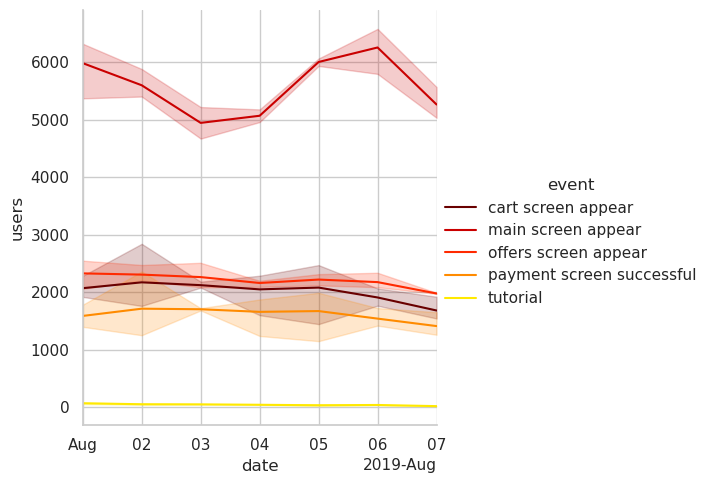

In [44]:
# create pivot table
temp_pivot_2 = (df_logs_exp_2.pivot_table(index=['date','name','group'], 
                                          values='user_id', 
                                          aggfunc='count').reset_index().rename_axis('', axis=1)
                .rename(columns={'user_id':'users', 'name':'event'}))

# create the plot
a = sns.relplot(data=temp_pivot_2, x='date', y='users', hue='event',kind='line')

# set the x-axis to display dates
a.set(xlim=(temp_pivot_2['date'].min(), temp_pivot_2['date'].max()))

# set the date formatter and locator
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
a.ax.xaxis.set_major_locator(locator)
a.ax.xaxis.set_major_formatter(formatter)

plt.show()

*The graph displays the fluctuation of the main_screen_appear event line over the week, while the other events remain more consistent. The confidence interval area indicates a noticeable difference in patterns between groups. The next graph will show a more detailed view of the event lines for each group, which are A1, A2, and B.*

/home/katia/miniconda3/envs/tts4/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



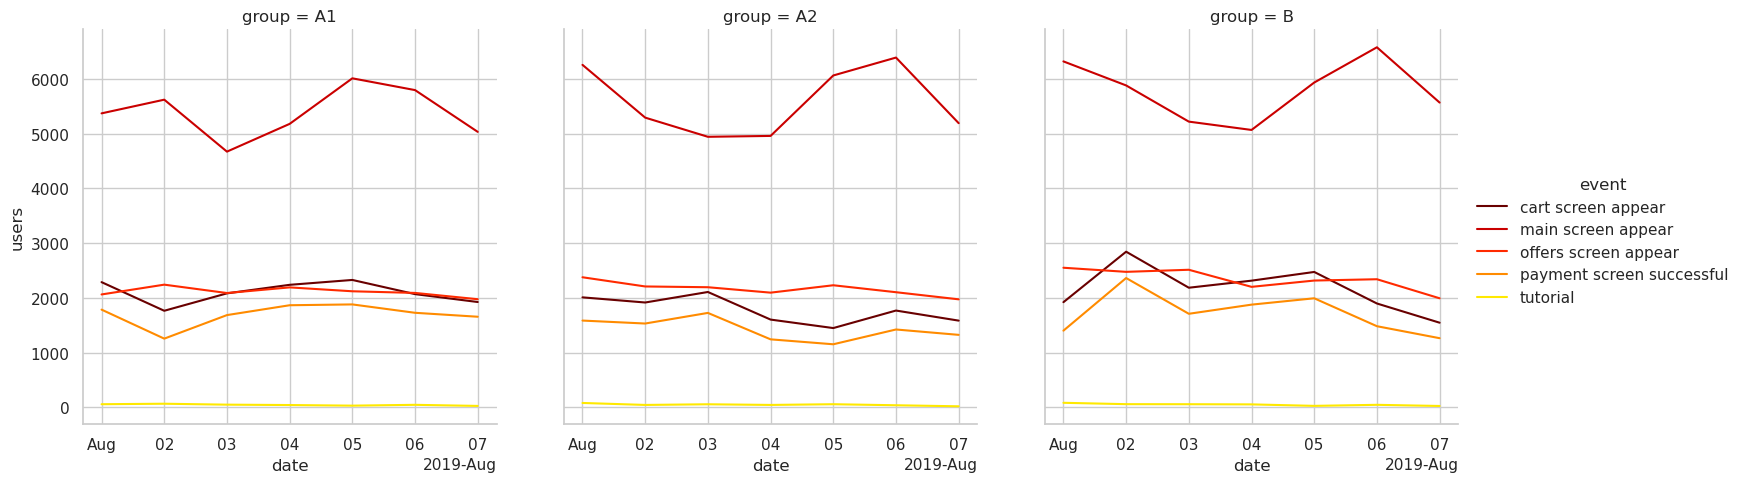

In [45]:
b = sns.relplot(data=temp_pivot_2, x='date', 
                y='users', hue='event', col='group', kind='line')

for ax in b.axes.flat:
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

*The graph highlights that although each event within each group has a similar y value range, they have different fluctuations each day. The significance of these differences will be tested using Mann Whitney testing in the A/A/B testing process.*

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Excelente visualização. A única consideração é sobre as grades da figura, como comentei anteriormente em outra seção do seu projeto. Obs.: Você não precisa remover completamente as grades se achar que elas ajudam, mas pode, por exemplo, reduzir a sua intensidade para dar mais ênfase às linhas de dados na sua figura.
</div>

### A/A/B Testing Preparation 

*In this section, we will prepare for A/A/B testing by creating a new dataframe and defining several functions. We will first generate cumulative data of each event by group and visualize it to seek for peeking problems. Then, we will calculate the relative difference of cumulative data to compare the performance of each group and found the indication of an outlier. Finally, if we found no sharp spike or drop for each event, we will perform Mann-Whitney testing to see if the differences between group are statistically significant.*

#### Cumulative Data of each Event by Group 

The following code first creates a pivot table from `df_logs_exp_2` using the `pd.pivot_table` function. It aggregates the count of user IDs for each unique combination of date, group, and event name. The resulting pivot table has a hierarchical index with the first level being the date and group, and the second level being the event name.

Then, a new column named `'conversion'` is created by dividing the count of `payment screen successful` events by the count of `main_screen_appear` events.

Next, cumulative sums are computed for each event and group using the `cumsum` function on the groupby object. The resulting dataframe is concatenated with the date and group columns from the original `event_pivot` dataframe to form the `cumulative_event` dataframe.

Finally, the `head` function is used to display the first few rows of the `cumulative_event` dataframe.

In [46]:
event_pivot = (pd.pivot_table(df_logs_exp_2, values='user_id', 
                              index=['date', 'group'], columns=['name'],  
                              aggfunc='count').reset_index().rename_axis('', axis=1))

event_pivot['conversion'] = event_pivot['payment screen successful'] / event_pivot['main_screen_appear']
cumsum_event = event_pivot.groupby('group').cumsum()
cumulative_event = pd.concat([event_pivot[['date', 'group']], cumsum_event], axis=1)

cumulative_event.head()

TypeError: datetime64 type does not support cumsum operations

#### Visualizing Cumulative Data

The purpose of the `visualize_cumulative` function is to create a visualization of the cumulative values of a given event for three groups: A1, A2, and B. The function takes the event as an input and outputs a graph that shows the cumulative values of the event over time for each group. The graph provides an easy way to compare the performance of the groups in terms of the given event.

In [ ]:
def visualize_cumulative(event):
    group_A1= cumulative_event[cumulative_event['group'] == 'A1'][['date', event]]
    group_A2= cumulative_event[cumulative_event['group'] == 'A2'][['date', event]]
    group_B= cumulative_event[cumulative_event['group'] == 'B'][['date', event]]
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=group_A1['date'], y=group_A1[event], name='A1', line=dict(color='#b50404')))
    fig.add_trace(go.Scatter(x=group_A2['date'], y=group_A2[event], name='A2', line=dict(color='#d15d04')))
    fig.add_trace(go.Scatter(x=group_B['date'], y=group_B[event], name='B', line=dict(color='#f5e905')))
    
    temp_title = 'Cumulative ' + event
    fig.update_layout(title=temp_title, xaxis_title='Date', yaxis_title=event)
    fig.show()

#### Relative Difference of Cumulative Data

The purpose of the `visualize_rel_diff` function is to plot a graph showing the relative difference in the cumulative data for a given event between the control group and the test groups (A1 and A2). The function takes the event as an input and performs the necessary data manipulations to calculate the relative difference between the groups. The resulting graph is a line plot with the date on the x-axis and the relative difference on the y-axis, with separate lines for the A1 and A2 test groups. The function uses the `go.Figure()` object from the Plotly library to create the plot, and the hovertemplate parameter to add interactive tooltips displaying the date and the relative difference for each point on the graph. The function also includes a horizontal line at zero to indicate no difference between the groups.

In [ ]:
def visualize_rel_diff(event):
    group_A1 = cumulative_event[cumulative_event['group'] == 'A1'][['date', event]]
    group_A2 = cumulative_event[cumulative_event['group'] == 'A2'][['date', event]]
    group_B = cumulative_event[cumulative_event['group'] == 'B'][['date', event]]
    
    merged_cumulative_A = group_A1.merge(group_A2, left_on='date', right_on='date', how='left', suffixes =['A1', 'A2'])
    merged_cumulative = merged_cumulative_A.merge(group_B, left_on='date', right_on='date', how='left')
    
    column_A1 = event + 'A1'
    column_A2 = event + 'A2'
    
    xaxis = merged_cumulative['date']
    yaxis1 = merged_cumulative[event] / merged_cumulative[column_A1] - 1
    yaxis2 = merged_cumulative[event] / merged_cumulative[column_A2] - 1
    
    temp_title = 'Relative difference of ' + event + ' cumulative between test group and control group'
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=xaxis, y=yaxis1, mode='lines', name='Group B vs A1', line=dict(color='#f7020f'),
                             hovertemplate='Date: %{x}<br>' + 'Relative ' + event + ' gain: %{y:.2%}<br>'))
    
    fig.add_trace(go.Scatter(x=xaxis, y=yaxis2, mode='lines', name='Group B vs A2', line=dict(color='#fa5f05'),
                             hovertemplate='Date: %{x}<br>' + 'Relative ' + event + ' gain: %{y:.2%}<br>'))
    
    fig.update_layout(title=temp_title, xaxis_title='Date', yaxis_title='Relative Difference', 
                      shapes=[dict(type='line', x0=xaxis.min(), x1=xaxis.max(), y0=0, y1=0, line=dict(dash='dash'))])
    fig.show()

#### Mann-Whitney U Test 

*The Mann-Whitney U test is a non-parametric statistical hypothesis test used to compare two groups of data to determine whether they have a significant difference. It is used when the assumptions of a t-test are not met, such as when the data is not normally distributed or the variance is not equal between the two groups.

In the context of A/B testing, the Mann-Whitney U test can be used to compare the distributions of a specific event between two groups, for example, to determine whether there is a significant difference in the number of users who completed a certain action between a test group and a control group.

The code provided defines two functions, `mannwhitneyu_test` and `significance_testing`, which perform Mann-Whitney U tests on different combinations of groups and events. The mannwhitneyu_test function takes in an event and two groups as arguments, and outputs the results of the Mann-Whitney U test, including the p-value and whether the null hypothesis should be rejected. The `significance_testing` function calls the `mannwhitneyu_test` function for three different combinations of groups and events, allowing for easy comparison of the results.*

In [ ]:
def mannwhitneyu_test(event, group_1, group_2):
    sample_1 = event_pivot[event_pivot['group'] == group_1][event]
    sample_2 = event_pivot[event_pivot['group'] == group_2][event]
    
    results = st.mannwhitneyu(sample_1, sample_2)
    alpha = 0.05
    
    print('Statistical significance of', event, 'count differences for group', group_1 , 'and group', group_2)
    print('p-value: ', results.pvalue.round(3))
    
    if (results.pvalue < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between the proportions")
    else:
        print("Failed to reject the null hypothesis, there is no reason to consider the proportions different")   
    print('Relative', event, 'gain for group', group_2, ':', '{0:.3f}'.format(sample_2.mean() / sample_1.mean() - 1))
    
def significance_testing(event):
    mannwhitneyu_test(event,'A1','A2')
    print()
    mannwhitneyu_test(event,'A1','B')
    print()
    mannwhitneyu_test(event,'A2','B')

### A/A/B Testing of Visitor Data 

*In this project, the app visitors will be define as those who atleast open the main screen. Therefore, we will run A/A/B testing on average visitor data from the value of main_screen_appear from `event_pivot` dataframe.*

#### Cumulative Visitor by Group 

*Before we dive in right away to the main parameter, we have to look for the cumulative visitor and analyze the chart to prevent peeking problems from occuring. We can use the pre-defined `visualize_cumulative` function to generate this chart.*

*Looking at the chart, we can see that the number of visitors in each group is increasing in a consistent manner during the testing period. This is a good indication that there are no outliers in our data.*

In [ ]:
visualize_cumulative('main_screen_appear')

#### Relative Difference of Cumulative Visitor 

*In order to further understand the performance of our test group (B) compared to the control groups (A1 and A2), we utilized the pre-defined `visualize_rel_diff` function to generate a graph showing the relative difference between the cumulative visitors from each group. The resulting visualization indicates that group B consistently outperforms both control groups in terms of cumulative visitors.*

*To investigate whether these differences are statistically significant, we will conduct a Mann Whitney U test.*

In [ ]:
visualize_rel_diff('main_screen_appear')

#### Statistical Significance of Average Visitor Differences

*The `significance_testing` function uses the Mann-Whitney U test to compare the `main_screen_appear` event between three different groups: A1, A2, and B. The p-values for all comparisons were higher than 0.05, indicating that there is no statistically significant difference between the proportions of visitors in each group who performed the `main_screen_appear` event.*

*However, it is worth noting that the average number of visitors for group B was 7.7% higher than group A1 and 3.8% higher than group A2. While the difference is not statistically significant, it may still be worth further investigation to understand the potential reasons behind the higher number of visitors in group B.*

In [ ]:
significance_testing('main_screen_appear')

Statistical significance of main screen appear count differences for group A1 and group A2
p-value:  0.62
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative main screen appear gain for group A2 : 0.038

Statistical significance of main screen appear count differences for group A1 and group B
p-value:  0.209
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative main screen appear gain for group B : 0.077

Statistical significance of main screen appear count differences for group A2 and group B
p-value:  0.535
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative main screen appear gain for group B : 0.038


#### Intermediate Conclusion 

*In conclusion, the A/A/B testing conducted on the average visitor data for the `main_screen_appear` event indicated that there were no statistically significant differences between the proportions of visitors in each group who performed this event.*

*However, the test group (B) consistently outperformed both control groups (A1 and A2) in terms of cumulative visitors, with the average number of visitors for group B being higher than both control groups. While the difference was not statistically significant, it may still be worth further investigation to understand the potential reasons behind the higher number of visitors in group B. Overall, the consistent increase in the number of visitors in each group during the testing period indicates that there were no outliers in our data.*

### A/A/B Testing of Interested Users Data

*In this section, we will be performing the same steps as in the previous section to analyze our A/A/B test results. However, this time we will be using the OffersScreenAppear event to define our interested users. These are the users who have shown interest in our app by performing this action.*

*We will start by generating a cumulative event by group graph and analyzing it to ensure there are no peeking problems. Next, we will use the pre-defined `visualize_rel_diff` function to generate a graph showing the relative difference in the cumulative number of interested users between our test group (B) and the control groups (A1 and A2).*

*Finally, we will conduct the Mann Whitney U test to investigate whether any statistically significant differences exist between the proportions of interested users in each group.*

#### Cumulative Interested Users by Group

*Upon analyzing the cumulative interested users by group chart, we can observe a consistent increase in the number of interested users in each group during the testing period. This suggests that there are no outliers in our data, similar to the previous section.*

*However, one noticeable difference is that the gap between group B and the control groups appears to be wider on the last day of testing. This could indicate a potential difference in the effectiveness of the tested feature on that particular day. Further investigation is necessary to determine if this difference is statistically significant.*

In [ ]:
visualize_cumulative('offers screen appear')

#### Relative Difference of Cumulative Interested Users

*The resulting visualization indicates that group B consistently outperforms both control groups in terms of cumulative interested users.*

*To investigate whether these differences are statistically significant, we will conduct a Mann Whitney U test.*

In [ ]:
visualize_rel_diff('offers screen appear')

#### Statistical Significance of Average Interested Users Differences 

*The Mann-Whitney U test was used by the `significance_testing` function to compare the proportion of interested users who performed the `offers screen appear` event among A1, A2, and B groups. Results showed that there was no significant difference between the proportions of interested users between A1 vs A2 and A2 vs B as their p-values were greater than 0.05.*

*However, the p-value of A1 vs B comparison was smaller than 0.05, which indicates a significant difference between the proportions of interested users in group B and group A1. The average number of interested users for group B was 11% higher than group A1 and 8% higher than group A2.*

In [ ]:
significance_testing('offers screen appear')

Statistical significance of offers screen appear count differences for group A1 and group A2
p-value:  0.318
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative offers screen appear gain for group A2 : 0.028

Statistical significance of offers screen appear count differences for group A1 and group B
p-value:  0.026
Rejecting the null hypothesis: there is a significant difference between the proportions
Relative offers screen appear gain for group B : 0.110

Statistical significance of offers screen appear count differences for group A2 and group B
p-value:  0.097
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative offers screen appear gain for group B : 0.080


#### Intermediate Conclusion 

*In conclusion, our A/A/B test on interested users showed that the tested feature consistently outperformed both control groups in terms of cumulative interested users. The Mann Whitney U test revealed that there was no significant difference in the proportion of interested users who performed the offers screen appear event between A1 vs A2 and A2 vs B, but a significant difference was observed between A1 vs B.*

*The average number of interested users for group B was 11% higher than group A1 and 8% higher than group A2. Although the difference in the cumulative interested users between group B and the control groups appeared to be wider on the last day of testing, further investigation is necessary to determine if this difference is statistically significant.*

*Overall, In terms of generating users who take action to load the offer page, these results suggest that the tested feature is effective. However, to determine whether altering the app font is succesfully increasing user interest and engagement with the app, we will have to dive further into the next step of the event funnel.*

### A/A/B Testing of Add-to-Cart Users Data 

*In this section, we will be using the `cart screen appear` event to define our add-to-cart users, who have shown interest in our app by adding items to their cart. We will perform the same steps as in the previous sections to analyze our A/A/B test results.*

*We will start by generating a cumulative event by group graph and analyzing it to ensure there are no peeking problems. Next, we will use the pre-defined `visualize_rel_diff` function to generate a graph showing the relative difference in the cumulative number of add-to-cart users between our test group (B) and the control groups (A1 and A2).*

*Finally, we will conduct the Mann Whitney U test to investigate whether any statistically significant differences exist between the proportions of add-to-cart users in each group.*

#### Cumulative Add-to-Cart Users by Group

*Upon analyzing the cumulative add-to-cart users by group chart, we can observe a consistent increase in the number of add-to-cart users in each group during the testing period. This suggests that there are no outliers in our data. The gap between group A2 to the others on the last testing day seems to be wider compared to the 2 previous section.*

In [ ]:
visualize_cumulative('cart screen appear')

#### Relative Difference of Cumulative Add-to-Cart Users

*During the initial testing day, group B didn't surpass the performance of both control groups in the funnel for the first time. Nevertheless, starting from the second day until the final day, group B has persistently performed better than both control groups when it comes to the cumulative add-to-cart users. We will carry out a Mann Whitney U test to determine if these variations are statistically significant.*

In [ ]:
visualize_rel_diff('cart screen appear')

#### Statistical Significance of Average Add-to-Cart Users Differences 

*The `significance_testing` function utilized the Mann-Whitney U test to compare the proportion of add-to-cart users who performed the `cart screen appear` event in groups A1, A2, and B. The results revealed that there was no significant difference between the proportions of interested users in A1 vs B and A2 vs B since their p-values were greater than 0.05.*

*However, the comparison of A1 vs A2 had a p-value smaller than 0.05, indicating a significant difference in the proportions of interested users between these two groups. Therefore, the A/A test was unsuccessful for this funnel as it shows a significant difference. Additionally, the average number of add-to-cart users in group B was 3.3% higher than group A1 and 22% higher than group A2.*

In [ ]:
significance_testing('cart screen appear')

Statistical significance of cart screen appear count differences for group A1 and group A2
p-value:  0.038
Rejecting the null hypothesis: there is a significant difference between the proportions
Relative cart screen appear gain for group A2 : -0.154

Statistical significance of cart screen appear count differences for group A1 and group B
p-value:  0.902
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative cart screen appear gain for group B : 0.033

Statistical significance of cart screen appear count differences for group A2 and group B
p-value:  0.097
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative cart screen appear gain for group B : 0.221


#### Intermediate Conclusion 

*In conclusion, the A/A/B testing of add-to-cart users data showed consistent increases in the number of add-to-cart users in each group during the testing period, suggesting no outliers in the data. Group B consistently outperformed both control groups in terms of cumulative add-to-cart users from day 2 to the final day, although it did not perform as well as the control groups on the first day.* 

*The Mann Whitney U test conducted showed no significant difference between the proportions of interested users in A1 vs B and A2 vs B, while the comparison of A1 vs A2 showed a significant difference. This indicates that the A/A test was unsuccessful for this funnel as it shows a significant difference. Moreover, the average number of add-to-cart users in group B was 3.3% higher than group A1 and 22% higher than group A2.*

### A/A/B Testing of Buyers Data

*In this section, we will be using the `payment screen successful` event to define our buyers, who have succesfully done a payment of our product. We will perform the same steps as in the previous sections to analyze our A/A/B test results.*

*We will start by generating a cumulative event by group graph and analyzing it to ensure there are no peeking problems. Next, we will use the pre-defined visualize_rel_diff function to generate a graph showing the relative difference in the cumulative number of buyers between our test group (B) and the control groups (A1 and A2).*

*Finally, we will conduct the Mann Whitney U test to investigate whether any statistically significant differences exist between the proportions of buyers in each group.*

#### Cumulative Buyers by Group

*The resulting graph is closely similar to the add-to-cart users cumulative. The group B start lower than the others and ended up the highest. The gap between group A2 to the other also wider on the last testing day.*

In [ ]:
visualize_cumulative('payment screen successful')

#### Relative Difference of Cumulative Buyers

*Relative difference of cumulative buyers between test group to the control group fluctuate and fail to show any consistent pattern. Further investigation is necessary to determine if this difference is statistically significant.*

In [ ]:
visualize_rel_diff('payment screen successful')

#### Statistical Significance of Average Buyers Differences

*The Mann-Whitney U test was used by the `significance_testing` function to compare the proportion of buyers who performed the `payment screen successful` event among A1, A2, and B groups. The results revealed that there was no significant difference between the proportions of interested users in A1 vs B and A2 vs B since their p-values were greater than 0.05.*

*However, the comparison of A1 vs A2 had a p-value smaller than 0.05, indicating a significant difference in the proportions of average buyers between these two groups. Therefore, the A/A test was unsuccessful for this funnel as it shows a significant difference. Additionally, the average number of buyers in group B was 2.1% higher than group A1 and 21% higher than group A2.*

In [ ]:
significance_testing('payment screen successful')

Statistical significance of payment screen successful count differences for group A1 and group A2
p-value:  0.026
Rejecting the null hypothesis: there is a significant difference between the proportions
Relative payment screen successful gain for group A2 : -0.158

Statistical significance of payment screen successful count differences for group A1 and group B
p-value:  0.902
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative payment screen successful gain for group B : 0.020

Statistical significance of payment screen successful count differences for group A2 and group B
p-value:  0.165
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative payment screen successful gain for group B : 0.211


#### Intermediate Conclusion 

*In this section, the PaymentScreenSuccessful event was used to identify buyers, and the A/A/B test was conducted to analyze the test results. The cumulative buyers by group graph shows that group B started with the lowest number of buyers and ended up with the highest number, while the gap between group A2 and the other groups was wider on the last testing day.* 

*The relative difference of cumulative buyers between the test group and the control groups fluctuated and failed to show any consistent pattern. The Mann-Whitney U test was conducted to determine the statistical significance of the average buyers' differences, and the results revealed that there was no significant difference between the proportions of interested users in A1 vs B and A2 vs B.*

*However, there was a significant difference in the proportions of average buyers between A1 and A2. Therefore, the A/A test was unsuccessful for this funnel, and the average number of buyers in group B was 2.1% higher than group A1 and 21% higher than group A2. Further investigation is necessary to determine the cause of the fluctuations in the relative difference of cumulative buyers.*

### A/A/B Testing of Conversion Data

*The conversion rate was calculated by dividing the number of successful payments (`payment screen successful`) by the number of visits to the main screen (`main_screen_appear`).*

*This conversion rate is an important metric for evaluating the success of the test, as it indicates the percentage of users who successfully completed a purchase after visiting the main screen. By comparing the conversion rates between the control groups and the test group, we can determine whether the changes made to the app (in this case the font change) had a significant impact on user behavior.*

#### Cumulative Conversion by Group

*By looking at the resulting graph, we already could predicted how group B will fail to show significant increase in terms of conversion. This is the first and only metric where the test group fail to outperform the control group in terms of cumulative value.*

In [ ]:
visualize_cumulative('conversion')

####  Daily Conversion Rates 

*This graph only futher confirm that group B have lower conversion cumulative than group A1. The Mann Whitney U test will give us a better approach whether or not the group B turns out to be significantly worse than the control group.*

In [ ]:
visualize_rel_diff('conversion')

#### Statistical Significance of Average Conversion Differences 

*The Mann-Whitney U test was used by the `significance_testing` function to compare the proportion of `conversion` among A1, A2, and B groups. The p-values for all comparisons were higher than 0.05, indicating that there is no statistically significant difference between the proportions of conversion in each group. The results indicate that altering the font of our app did not have any impact on the user conversion rate, whether positive or negative.*

In [ ]:
significance_testing('conversion')

Statistical significance of conversion count differences for group A1 and group A2
p-value:  0.053
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative conversion gain for group A2 : -0.183

Statistical significance of conversion count differences for group A1 and group B
p-value:  1.0
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative conversion gain for group B : -0.048

Statistical significance of conversion count differences for group A2 and group B
p-value:  0.456
Failed to reject the null hypothesis, there is no reason to consider the proportions different
Relative conversion gain for group B : 0.165


#### Intermediate Conclusion

*The A/A/B testing of conversion data showed that changing the font did not have a significant impact on the user conversion rate. The conversion rates for all three groups did not show any statistically significant difference. The cumulative conversion and daily conversion rates graph also confirmed that group B did not outperform the control groups in terms of conversion. Therefore, the conclusion is that the font change did not improve the success of the app.*

## Final Conclusions

- This **project's aim** is to **investigate the sales funnel** and study user behaviour using an **A/A/B test** to see how **changes to the app's font affect user engagement**.
- Some **data pre-processing** was performed, such as **renaming columns**, **replacing values** with more practical names, as well as **converting** some columns to the appropriate **data types**. There was some **duplicated data**, but it was **removed** e there was **no missing data**.
- Preliminary **data exploration** reveals that our dataframe **contains** some **unnecessary data** from before the testing time. Removing this data **removed only 1.16% of the events** that occurred and **0.23% of the users**. This figure is insignificant in comparison to the total data and will not skew the analysis results.
- **Event Funnel Analysis**:
    - **Users follow a similar route** of main_screen_appear -> offers screen appear -> cart screen appear -> payment screen successful.
    - The stage with the **greatest loss is between the first and second**, with nearly 39% of users (more than 2,826 unique id) failing to advance to the next level.
    - More than **47% of users undergo the entire journey** from main screen to succesfully make a payment.
- **A/A/B Testing**:
    - **Mann Whitney U test** is used in this project
    - The test outcome demonstrates how the **test group outperformed the control group** in terms of **visitors** (main_screen_appear) and **interested users** (offers screen appear). However, the font change should have no effect on this stage of the event funnel because it has no effect on convincing first-time users to use the app and continue to the offer page.
    - The test reveals that the **test group are fail** to have an increase that is enough **to pass the signicant threshold** in terms of ***Add-to-Cart users*** (cart screen appear) and ***Buyers*** (payment screen successful).
    - The conversion value of test group are also failing to shows any increment compared to one of the control group.
- **A/A/B testing proved that changing the font of the app does not have the expected positive impact on user engagement**.